In [2]:
pip install opencv-python opencv-python-headless numpy torch torchvision

Image loaded successfully!


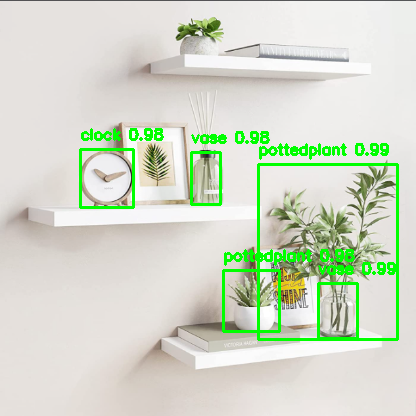

Output saved as 'detected_output.png'.


In [37]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

image = cv2.imread('/content/shelf1.png')

if image is None:
    print("Error: Image not found or path is incorrect.")
else:
    print("Image loaded successfully!")

resized_image = cv2.resize(image, (416, 416))

normalized_image = resized_image / 255.0

net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')

with open('coco.names', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# Creating blob from the image
blob = cv2.dnn.blobFromImage(resized_image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)

# Performing the forward pass
outputs = net.forward(output_layers)

# Extracting bounding boxes, confidences, and class IDs
height, width = resized_image.shape[:2]
boxes = []
confidences = []
class_ids = []

for output in outputs:
    for detection in output:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:  # to filter weak predictions
            # Extracting bounding box coordinates
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

# Checking if any bounding boxes were detected
if len(boxes) == 0:
    print("No objects detected in the image.")
else:
    # Applying Non-Maximum Suppression to avoid overlapping bounding boxes
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    # Check if NMS returns any valid indices
    if len(indices) > 0:
        for i in indices.flatten():  # This will flatten the indices array
            box = boxes[i]
            x, y, w, h = box[0], box[1], box[2], box[3]
            label = str(classes[class_ids[i]])
            confidence = confidences[i]
            # Draw bounding box
            cv2.rectangle(resized_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            # Display label and confidence
            cv2.putText(resized_image, f'{label} {confidence:.2f}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Showing the image with detections
        cv2_imshow(resized_image)

        # This saves the image with bounding boxes
        cv2.imwrite('detected_output.png', resized_image)
        print("Output saved as 'detected_output.png'.")
    else:
        print("No valid boxes after applying Non-Maximum Suppression.")